## Practica 03: Projecció prespectiva + Calibratge Càmera

In [128]:
import numpy as np    
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns


path_calib = ['Imatges/Calibracio/'+ x for x in os.listdir('Imatges/Calibracio')]
path_cas1 = ['Imatges/Cas1/' + x for x in os.listdir('Imatges/Cas1')]
path_cas2 = ['Imatges/Cas2/' + x for x in os.listdir('Imatges/Cas2')]

In [129]:
def find_chess_board(img, squares):
    retval, corners = cv2.findChessboardCorners(img, squares, None)
    if not retval:
        raise Exception('Corners no trobats')
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    corners2 = cv2.cornerSubPix(img,corners, (11,11), (-1,-1), criteria)
    im = cv2.drawChessboardCorners(img, squares, corners2, retval)
    return corners2, im

def homography_matrix(corners, squares):

    ## Estructura per taula amb les característiques del enunciat
    x_p = [(30*9*0.75) + 30 * n for n in range(squares[0])]
    y_p = [(30*6*0.75) + 30 * n for n in range(squares[1])]
    m = np.zeros_like(corners)
    c = 0
    for y in y_p:
        for x in x_p:
            m[c] = np.array([x,y])
            c += 1
    h ,status = cv2.findHomography(corners,m)

    return h

def prespecitve(h, img):
    return cv2.warpPerspective(img, h, (675,450))  


def read_gray(path):
    pattern = cv2.imread(path)
    pattern_gray =  cv2.cvtColor(pattern, cv2.COLOR_BGR2GRAY)
    return pattern_gray

def plot_org_top(im1,im2):
    fig, (ax0, ax1) = plt.subplots(1,2, figsize = (20,20))
    ax0.title.set_text('Original')
    ax0.imshow(im1, cmap = 'gray')
    ax1.title.set_text('cv2 homography')
    ax1.imshow(im2, cmap = 'gray')

def canny_filter(img):
    low_threshold = 100
    high_threshold = 120
    edges = cv2.Canny(img, low_threshold, high_threshold)
    return edges

### 1: Detecció i Caracterització de les peces circulars

#### Cas 1

In [130]:
patro1 = cv2.imread(path_cas1[0])
patro1_gray = read_gray(path_cas1[0])
img1 = read_gray(path_cas1[1])

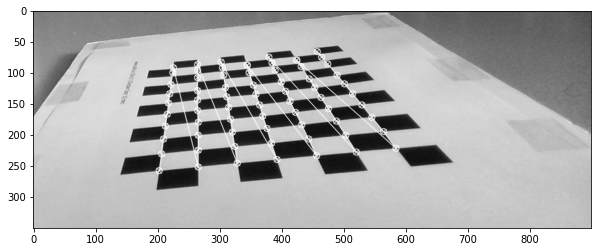

In [131]:
corners1, im1 = find_chess_board(patro1_gray[-350:,-900:], (10,7))
plt.figure(figsize = (10,10))
plt.imshow(im1, cmap = 'gray')

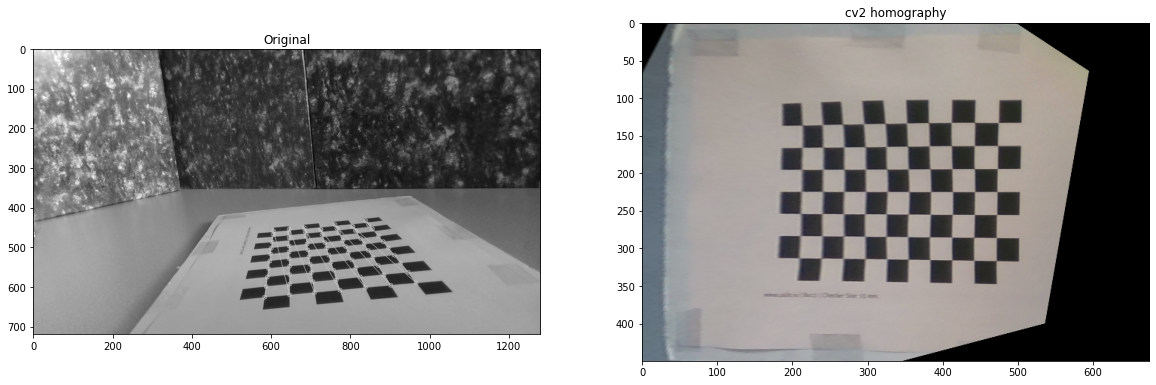

In [150]:
h1 = homography_matrix(corners1, (10,7))
top1 = prespecitve(h1, patro1[-350:,-900:])
plot_org_top(patro1_gray, top1)

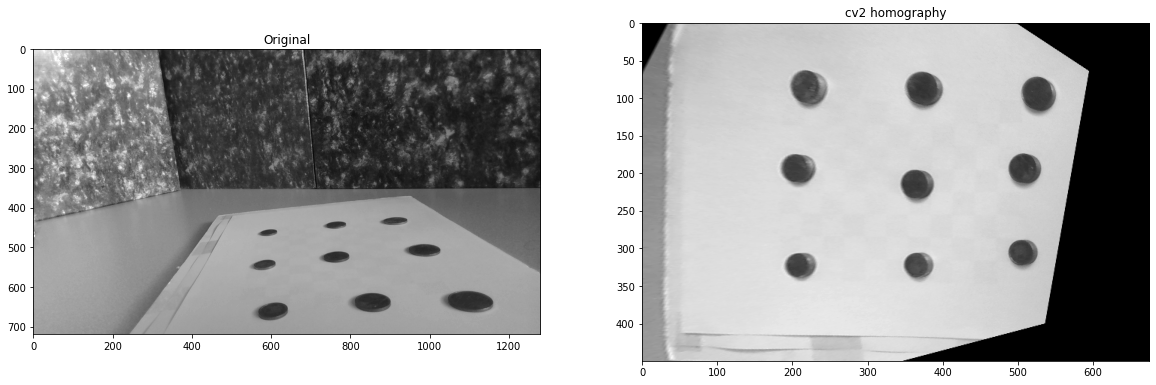

In [145]:
top_coin1 = prespecitve(h1, img1[-350:,-900:])
plot_org_top(img1, top_coin1)

#### Cas 2

In [134]:
patro2 = cv2.imread(path_cas2[0])
patro2_gray = read_gray(path_cas2[0])
img2 = read_gray(path_cas2[1])

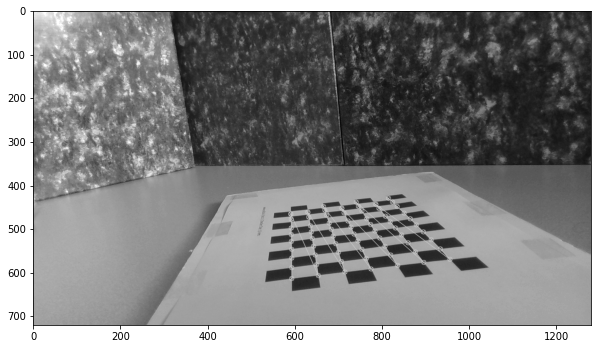

In [135]:
corners2, im2 = find_chess_board(patro2_gray, (10,7))
plt.figure(figsize = (10,10))
plt.imshow(im2, cmap = 'gray')

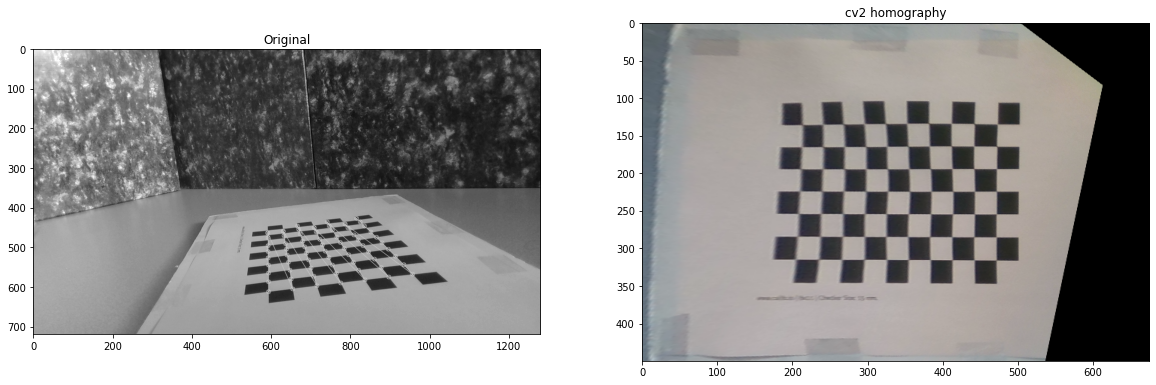

In [136]:
h2 = homography_matrix(corners2, (10,7))
top2 = prespecitve(h2, patro2)
plot_org_top(patro2_gray, top2)

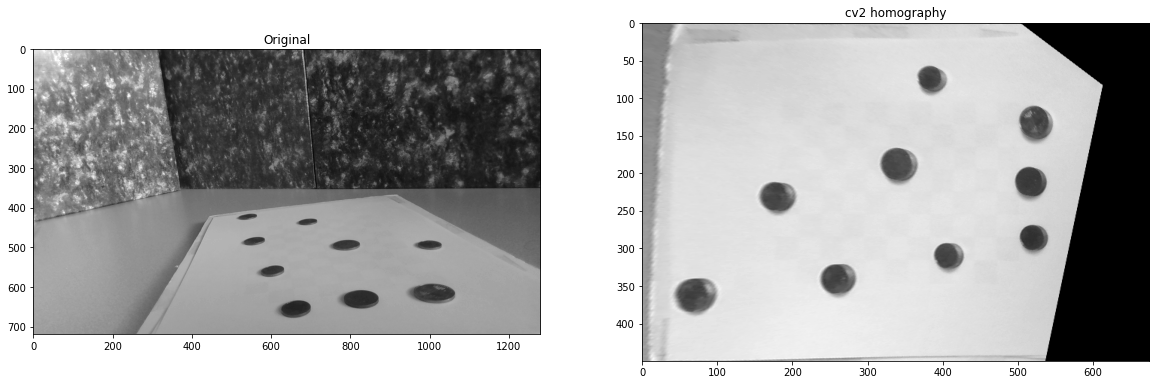

In [137]:
top_coin2 = prespecitve(h2, img2)
plot_org_top(img2, top_coin2)

## 2 Càmera